<a href="https://colab.research.google.com/github/zscialom/RL_Research/blob/heatmaps/MLOFI-1month-10-symbol-stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLOFI  - statistical tests - November 2014 - 10 symbols

### Import the necessary libraries

In [24]:
# import packages
import numpy as np
import matplotlib
import pandas as pd
from scipy.stats import norm
import copy
from tqdm import tqdm 
import time
import os
import glob

import scipy.io as sio  # for loading matlab data
import csv
from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
from statsmodels.tsa import stattools
from statsmodels.graphics import gofplots
from scipy import stats
from statsmodels.tsa import arima_model
from statsmodels.regression import linear_model
import statsmodels.api as sm

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [54]:
def get_ridge(t,es, microprice, maxlevel, frequency):
  #t_test=tradingTime[0:n]
  #T= len(t_test)
  T= len(t)
  X_train = np.zeros([T, maxlevel])

  for i in range(maxlevel):
    X_train[:, i] = es[i][t]

  scaler = StandardScaler().fit(X_train[:-1,:])
  X_train = scaler.transform(X_train[:-1,:])


  #X_train =np.diff(X_train, axis=0)
  y_train = np.diff(microprice[t*frequency])
  mu = np.mean(y_train)
  std= np.std(y_train)
  y_train=(y_train-mu)/std

  #define cross-validation method to evaluate model
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

  #define model
  model = RidgeCV(alphas=np.arange(0.01, 1, 0.01), cv=cv, scoring='neg_mean_absolute_error')

  #fit model
  model.fit(X_train, y_train)

  #display lambda that produced the lowest test MSE
  print(model.alpha_)
  return model, X_train, y_train

In [2]:
%matplotlib inline

In [48]:
def get_mlofi(bidvol, askvol, delta_bid_prices, delta_ask_prices,t, frequency, maxlevel):

  delta_Ws = []
  delta_Vs = []
  for i in range(maxlevel):
    delta_W=np.array([0]*len(t))
    delta_V=np.array([0]*len(t))
    
    print('level {}'.format(i))  
    idx=np.where(delta_bid_prices[:,i]>0)[0]
    
    delta_W[idx]=bidvol[idx+1,i]
    idx=np.where(delta_bid_prices[:,i]==0)[0]
  
    delta_W[idx]=np.diff(bidvol[:,i])[idx]
    idx=np.where(delta_bid_prices[:,i]<0)[0]
    delta_W[idx]=-bidvol[idx,i]

    idx=np.where(delta_ask_prices[:,i]<0)[0]
    delta_V[idx]=askvol[idx+1,i]
    idx=np.where(delta_ask_prices[:,i]==0)[0]
    delta_V[idx]=np.diff(askvol[:,i])[idx]
    idx=np.where(delta_ask_prices[:,i]>0)[0]
    delta_V[idx]=-askvol[idx,i]

    delta_Ws.append(delta_W)
    delta_Vs.append(delta_V)

  es = []
  for i in range(maxlevel):
    e=delta_Ws[i]-delta_Vs[i]
    es.append(e.reshape(-1, frequency).mean(axis = 1)) 
  return es
    

In [52]:
def extract_data(data, ticker, date, frequency, maxlevel):

  LOB=data['LOB']

  # There is a pdf "Data_Description" that also details the field
  # The file contains a structure called LOB where each field has entries corresponding to one second of the trading day

  # time stamp is milliseconds from midnight at the start of the second
  time_adj = 1e-3                   # this number is for time adjustment, the time unite in raw data is millisecond
  price_adj = 1e-4                  # this number is for price correction, the price quoted in raw data is in price*1e4 form
  t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*time_adj  # time in seconds (hence 1e-3), measured from NASDAQ opening at 9:30am (hence 3600000*9.5)
  bid = np.array(LOB['BuyPrice'][0][0]*price_adj)                      # bid price in the given 0.1 second interval (1e-4 needed because of the way the data has been obtained)
  bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)                   # bid volumes in the given 0.1 second interval                  
  ask = np.array(LOB['SellPrice'][0][0]*price_adj)                     # ask price in the given 0.1 second interval
  askvol = np.array(LOB['SellVolume'][0][0]*1.0)                  # ask volumes in the given 0.1 second interval
  nMO = np.array(LOB['NumberMO'][0][0]*1.0)                       # total number of MOs submitted in the given 0.1 second interval
  vMO = np.array(LOB['VolumeMO'][0][0]*1.0)                       # total volume of MOs submitted in the given 0.1 second interval
  MO=np.array(LOB['MO'][0][0]*1.0)                                # information about market orders: number of MOs in the given 0.1 second interval
  dt = t[1]-t[0]                                                  # dt = 0.1 second
  
  delta_bid_prices = np.diff(bid[:,:maxlevel], axis=0)
  delta_ask_prices = np.diff(ask[:,:maxlevel], axis=0)
  microprice = (bid[:,0]*askvol[:,0]+ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

  es= get_mlofi(bidvol, askvol, delta_bid_prices, delta_ask_prices,t, frequency, maxlevel)

  #print(dt)
  #print(t[0])
  #print(t[-1])
  return es, microprice, t


### Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
tickers = ['AMZN', 'EBAY', 'FB', 'GOOG', 'INTC', 'MSFT', 'MU', 'PCAR', 'SMH', 'VOD']
maxlevel = 10 

In [50]:
#the timestamp is 0.1 second so we need to multiply the time by 10 to get everysecond
secondFreq = 10 # variable needed to work with seconds
oneMinute = 60 
trade_freq = secondFreq
# START TRADING: 13h00
# between 9:30 and 13:00: 3.5 hours so, 210 minutes
# work with 13:01 for convenience
tradStart = 218
initTime = (tradStart*secondFreq*oneMinute)-1       # time for 13:01 am

# STOP TRADING: 15:30 
# 16:00 - 30 minutes
#thirtyMin = 30*secondFreq*60                        # 30 minutes:
#thirtyMin = (178*60+55)*secondFreq                 # 16:00 - 2 hours 58 minutes 55 seconds 5steps
#thirtyMin = (170*60+20)*secondFreq                 # 16:00 - 2 hours 57 minutes 20 seconds 100steps
#thirtyMin = (178*60+50)*secondFreq                 # 16:00 - 2 hours 58 minutes 50 seconds 10steps
thirtyMin = (170*60+50)*secondFreq                 # 16:00 - 2 hours 58 minutes 10 seconds 50steps
# Length of estimation window - 1 hour
N = oneMinute*secondFreq                                
T0 = 0                                   # initial time for the initial state: time is discretized also, the value 0 is then treated as the initial trading time and so on

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.45


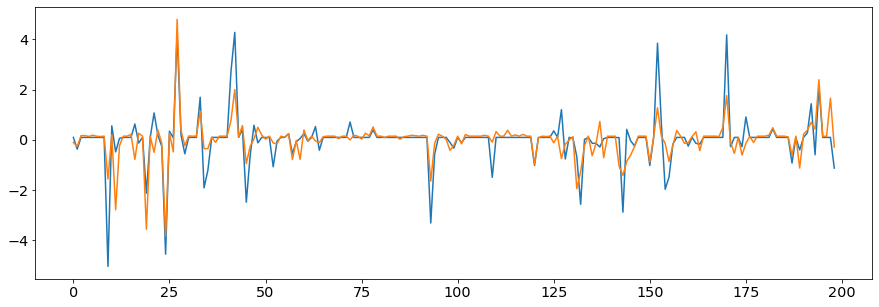

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.44


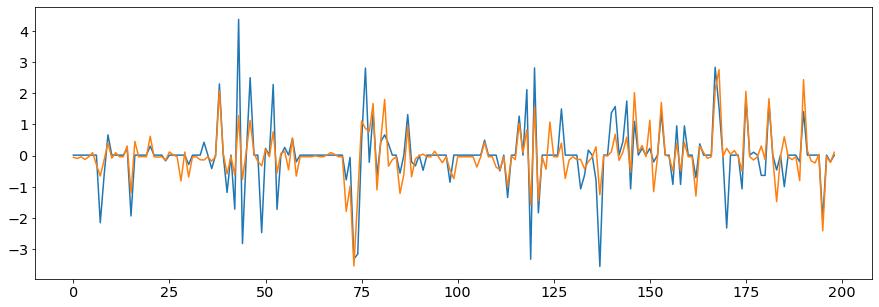

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.49


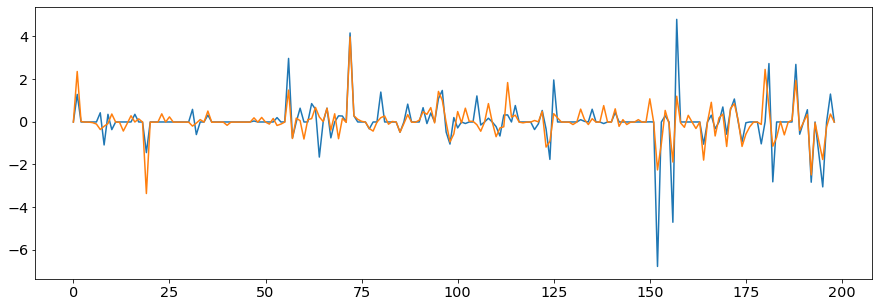

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.22


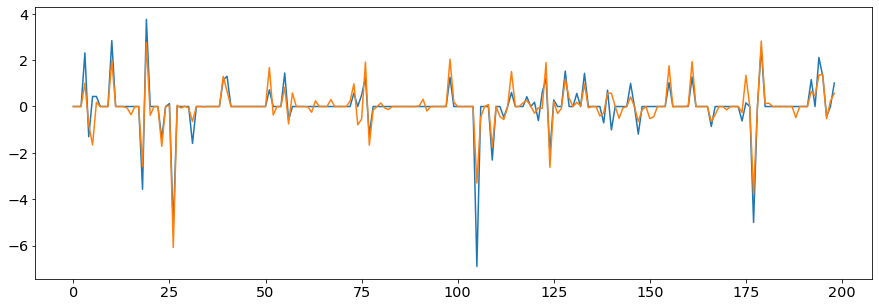

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.39


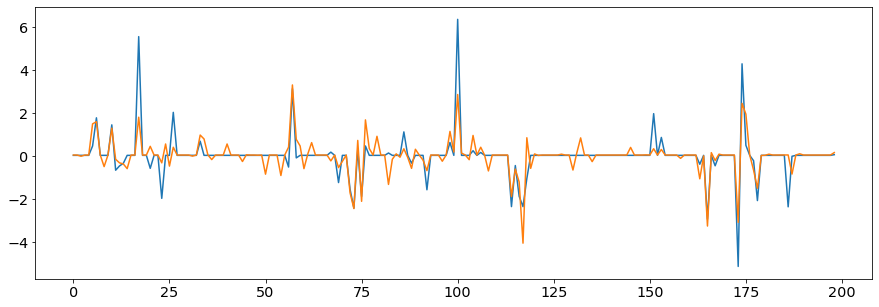

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.48


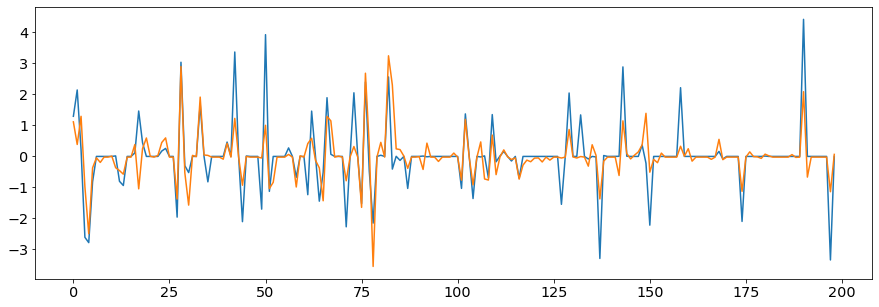

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.39


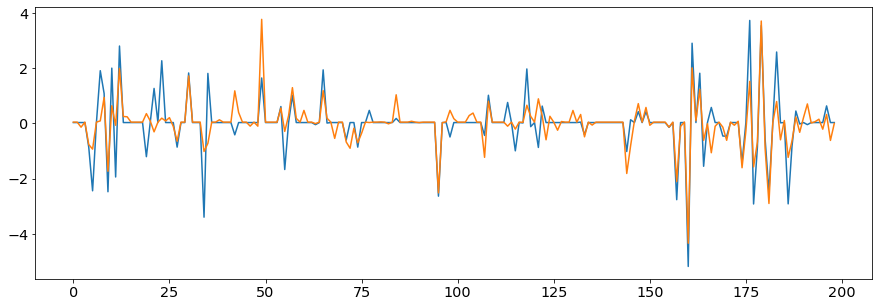

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400
0.99
MSE training set 0.34


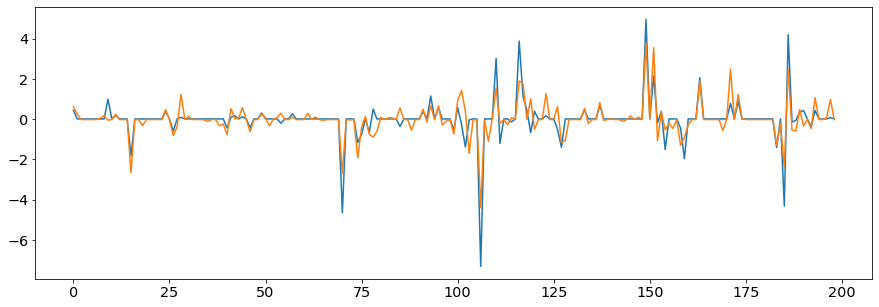

level 0
level 1
level 2
level 3
level 4
level 5
level 6
level 7
level 8
level 9
[13080 13081 13082 ... 23398 23399 23400]
10321
23400


KeyboardInterrupt: ignored

In [56]:
for ticker in tickers:

  dates = glob.glob('/content/drive/Shared drives/ProjectML/Project/Nov-2014/' + ticker + '_*.mat')
  #os.listdir('/content/drive/Shared drives/ProjectML/Project/Nov-2014/' + ticker + '_*.mat')
  for date in dates:
    data = sio.loadmat(date)
    (es, microprice, t) = extract_data(data, ticker, date, trade_freq, maxlevel)
     
    totalTime = len(t)           
    #tradingTime = t[initTime:totalTime-thirtyMin]       # trading window studied: 1:01pm to 3:30pm - 
    tradingTime = t[initTime:totalTime-0]       # trading window studied: 1:01pm to 3:30pm - 
    tradingTime = tradingTime[::trade_freq]             # take every second (for trading)
    tradingTime = np.array(list(map(int, tradingTime)),dtype='int')           # only deal with integers
    endTrading = int(tradingTime[-1])

    print(tradingTime)
    print(len(tradingTime))
    print(endTrading)
    n=200
    model, X_train, y_train = get_ridge(tradingTime[0:n],es, microprice, maxlevel, trade_freq) 
    pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 2))
    plt.plot(y_train)
    plt.plot(pred_train)
    plt.show()
  #print('R squared training set', round(model.score(X_train, y_train)*100, 2))

## Order Flow

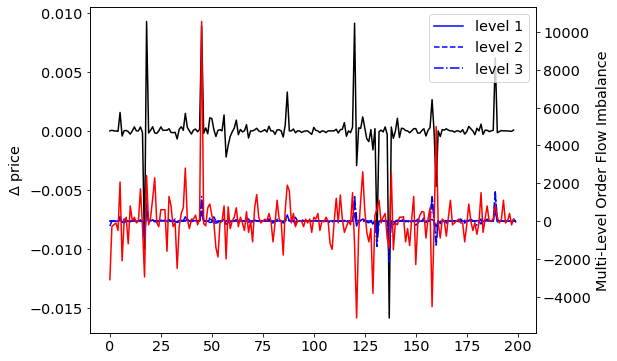

In [ ]:
#t[initTime:initTime+50],
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_ylabel('$\Delta$ price')
n=200
ax1.plot(np.diff(microprice[tradingTime[0:n]*secondFreq]), color='k')
ax2 = ax1.twinx() 
ax2.plot(es[0][tradingTime[0:n]], color='b', linestyle='-', label ='level 1')
ax2.plot(es[1][tradingTime[0:n]],color='b', linestyle='--', label = 'level 2')
ax2.plot(es[2][tradingTime[0:n]],color='b', linestyle='-.', label = 'level 3')

ax2.plot(np.diff(order_flow[tradingTime[0:n]*secondFreq]), color='r' )
ax2.set_ylabel('Multi-Level Order Flow Imbalance')
plt.legend()

### Statistic test for AR 1 model and OLS model

In [ ]:
t_ARtest_est_init = 211*60*10-1
t_ARtest_est_31min = 30*60*10
order_flow_sec_test = order_flow[t_ARtest_est_init-N:t_ARtest_est_init:10]
OF_AR1 = sm.tsa.AutoReg(order_flow_sec_test,1)
OF_AR1 = OF_AR1.fit()

OF_AR1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                   60
Model:                     AutoReg(1)   Log Likelihood                -514.268
Method:               Conditional MLE   S.D. of innovations           1476.565
Date:                Thu, 09 Mar 2023   AIC                           1034.537
Time:                        20:33:28   BIC                           1040.769
Sample:                             1   HQIC                          1036.970
                                   60                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3372.4434    711.354      4.741      0.000    1978.214    4766.672
y.L1           0.4641      0.111      4.191      0.000       0.247       0.681
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1547           +0.0000j            2.1547            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
t_OLStest_est_init = 211*60*10-1
t_OLStest_est_31min = 30*60*10
order_flow_OLStest_list = order_flow[t_OLStest_est_init-N:t_OLStest_est_init:10]
microprice_OLStest_list = microprice[t_OLStest_est_init-N:t_OLStest_est_init:10]
OLS_model = sm.OLS(np.diff(microprice_OLStest_list),np.diff(order_flow_OLStest_list))
OLS_model = OLS_model.fit()

OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.685
Method:                 Least Squares   F-statistic:                              129.0
Date:                Thu, 09 Mar 2023   Prob (F-statistic):                    2.24e-16
Time:                        20:33:30   Log-Likelihood:                          281.89
No. Observations:                  59   AIC:                                     -561.8
Df Residuals:                      58   BIC:                                     -559.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.739e-06   1.53e-07     11.359      0.000    1.43e-06    2.05e-06
==============================================================================
Omnibus:                       11.937   Durbin-Watson:                   2.610
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               29.449
Skew:                           0.386   Prob(JB):                     4.03e-07
Kurtosis:                       6.374   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
np.arange(t_OLStest_est_init-N,t_OLStest_est_init,10)

array([125999, 126009, 126019, 126029, 126039, 126049, 126059, 126069,
       126079, 126089, 126099, 126109, 126119, 126129, 126139, 126149,
       126159, 126169, 126179, 126189, 126199, 126209, 126219, 126229,
       126239, 126249, 126259, 126269, 126279, 126289, 126299, 126309,
       126319, 126329, 126339, 126349, 126359, 126369, 126379, 126389,
       126399, 126409, 126419, 126429, 126439, 126449, 126459, 126469,
       126479, 126489, 126499, 126509, 126519, 126529, 126539, 126549,
       126559, 126569, 126579, 126589])

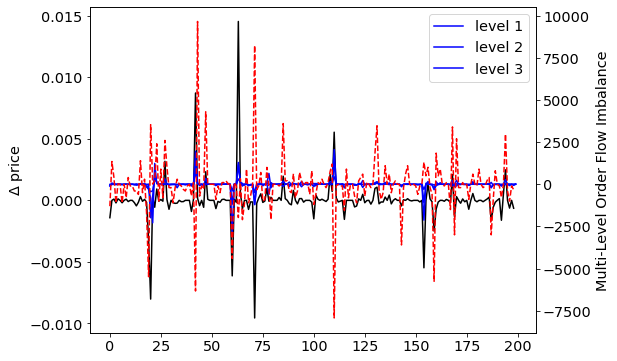

In [ ]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.set_ylabel('$\Delta$ price')
ax1.plot(np.diff(microprice[t_test*secondFreq]), color='k')
ax2 = ax1.twinx() 
ax2.plot(es[0][t_test], color='b', linestyle='-', label ='level 1')
ax2.plot(es[1][t_test], color='b', linestyle='-', label ='level 2')
ax2.plot(es[2][t_test], color='b', linestyle='-', label ='level 3')

ax2.set_ylabel('Multi-Level Order Flow Imbalance')
ax2.plot(np.diff(order_flow[t_test*secondFreq]), color='r' , linestyle='--')
plt.legend()

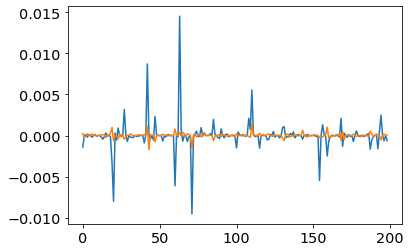

In [ ]:
X_train=np.diff(order_flow[t_test*secondFreq])
#X_train=es[0][t_test[:-1]]
y_train = np.diff(microprice[t_test*secondFreq])
#X_train = sm.add_constant(X_train)
OLS_model = sm.OLS(y_train,X_train)
OLS_model = OLS_model.fit()


pred_train = OLS_model.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(y_train)
plt.plot(pred_train)

In [ ]:
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.028
Model:                            OLS   Adj. R-squared (uncentered):              0.024
Method:                 Least Squares   F-statistic:                              5.797
Date:                Fri, 10 Mar 2023   Prob (F-statistic):                      0.0170
Time:                        08:29:50   Log-Likelihood:                          981.47
No. Observations:                 199   AIC:                                     -1961.
Df Residuals:                     198   BIC:                                     -1958.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.793e-07   7.45e-08     -2.408      0.017   -3.26e-07   -3.24e-08
==============================================================================
Omnibus:                      136.818   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6226.627
Skew:                           1.901   Prob(JB):                         0.00
Kurtosis:                      30.138   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from pandas import read_csv
from sklearn.linear_model import Lasso
# define model
t_test=tradingTime[0:n]
T= len(t_test)
X_train = np.zeros([T, maxlevel])

for i in range(maxlevel):
  X_train[:, i] = es[i][t_test]

scaler = StandardScaler().fit(X_train[:-1,:])
X_train = scaler.transform(X_train[:-1,:])


#X_train =np.diff(X_train, axis=0)
y_train = np.diff(microprice[t_test*secondFreq])
mu = np.mean(y_train)
std= np.std(y_train)
y_train=(y_train-mu)/std


cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
model = LassoCV(alphas=np.arange(0.01, 1, 0.01), cv=cv)

#model = LassoCV(cv=10, random_state=1, max_iter=10000)

# Fit model
model.fit(X_train, y_train)
print(model.alpha_)
# define new data
pred_train = model.predict(X_train)
# summarize prediction
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

0.01
MSE training set 0.09


In [ ]:
model.coef_

array([ 0.51940845, -0.29255013, -0.46540626,  0.00248745,  0.42897536,
        0.45701602,  0.33263397, -0.        , -0.        , -0.04663735])

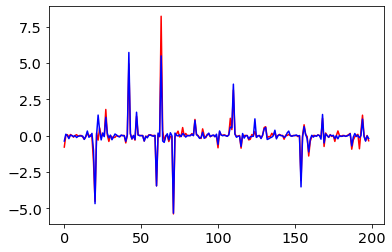

In [ ]:
plt.plot(y_train, 'red')
plt.plot(pred_train, 'blue')

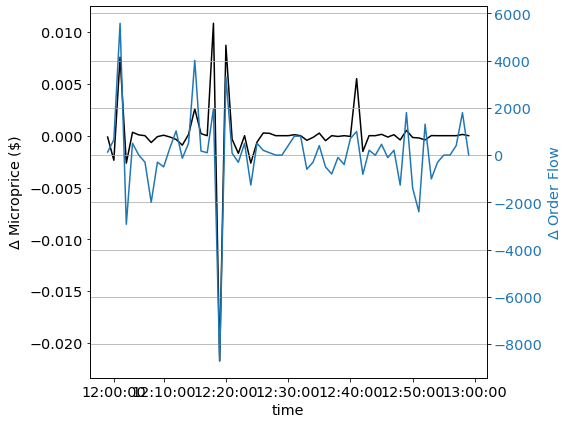

In [ ]:

#plt.plot(Xs_test, color='black')
#plt.plot(Xs_test_0_0_1, color='blue')
fig, ax1 = plt.subplots(figsize=(8,6))
color = 'black'
ax1.set_xlabel('time')
ax1.set_ylabel('$\Delta$'+ ' Microprice (\$)', color=color)
ax1.plot(t[t_OLStest_est_init-N:t_OLStest_est_init:10][:-1],np.diff(microprice_OLStest_list), color=color)

#ax1.plot(t[initTime:initTime+49], np.diff(microprice[tradingTime[0:50]*secondFreq]), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('$\Delta$' + ' Order Flow', color=color)


linestyle=['-', '--','-.',':']
#ax2.plot(t[initTime:initTime+50],order_flow[initTime:initTime+50], color=color, linestyle=linestyle[0], label='Order Flow')
ax2.plot(t[t_OLStest_est_init-N:t_OLStest_est_init:10][:-1],np.diff(order_flow_OLStest_list), color=color)
#plt.plot(results[0.01]['inventory'], color='green')
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks([12601, 12609, 12619, 12629, 12639, 12649, 12659], ['12:00:00', '12:10:00', '12:20:00','12:30:00','12:40:00','12:50:00', '13:00:00'], rotation=20)

#ax2.set_xticks([t[initTime], t[initTime+10], t[initTime+20], t[initTime+30], t[initTime+40], t[initTime+50]], ['13:01:00', '13:01:10', '13:01:20','13:01:30','13:01:40','13:01:50'], rotation=20)
#plt.ylabel('Inventory (Num. Blocks)')
#plt.xlabel('time')
fig.tight_layout()
#plt.legend()
plt.grid()
file_path= '/content/drive/Shared drives/ProjectML/Project/Temporary_Plots_Figures/'+ticker+'/'
fig.savefig(file_path+'Delta_OF_dpi1200.eps', format='eps', dpi=1200)
fig.savefig(file_path+'Delta_OF_dpi600.eps', format='eps', dpi=600)
fig.savefig(file_path+'Delta_OF_dpi300.eps', format='eps', dpi=300)

